In [7]:
spark.version

'3.1.3'

## Cleaning Data 

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, desc, month, year, length, corr
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt


In [9]:
spark = SparkSession.builder \
    .appName("Amazon Reviews Analysis") \
    .getOrCreate()

data_path = "gs://msca-bdp-amazon/amazon_reviews/"
df = spark.read.option("header", "true").option("delimiter", "\t").csv(data_path)

### Removing null values from Star Rating Column

In [46]:
#Removing null values early in the pipeline to reduce the data size for downstream processing
#This approach helps to minimize memory usage and reduces data shuffling during transformations.

In [10]:
df_cleaned = df.filter(df.star_rating.isNotNull())

print("Total rows after removing nulls:", df_cleaned.count())


Total rows after removing nulls: 150960015


In [11]:
product_category_counts = df_cleaned.groupBy("product_category").count().orderBy(desc("count"))
product_category_counts.show(truncate=False)

num_categories = df_cleaned.select("product_category").distinct().count()
print(f"Number of unique product categories: {num_categories}")


+----------------------+--------+
|product_category      |count   |
+----------------------+--------+
|Books                 |19531194|
|Digital_Ebook_Purchase|17622381|
|Wireless              |9001881 |
|PC                    |6908551 |
|Home                  |6221537 |
|Apparel               |5906322 |
|Health & Personal Care|5331215 |
|Beauty                |5115452 |
|Video DVD             |5069136 |
|Mobile_Apps           |5033376 |
|Kitchen               |4880460 |
|Toys                  |4864243 |
|Sports                |4849563 |
|Music                 |4751540 |
|Shoes                 |4366916 |
|Digital_Video_Download|4057147 |
|Automotive            |3514709 |
|Electronics           |3093861 |
|Pet Products          |2643614 |
|Office Products       |2642403 |
+----------------------+--------+
only showing top 20 rows



Number of unique product categories: 56


### Cleaning Product Categories

In [47]:
#Selecting only the required column ("product_category") to minimize the data being processed
#Applying .distinct() to eliminate duplicate categories, optimizing performance for high-cardinality data in Spark

In [12]:
unique_categories = df_cleaned.select("product_category").distinct().orderBy("product_category")

unique_categories.show(56, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_category                                                                                                                                                                                                                                                      

In [13]:
from pyspark.sql.functions import length

df_cleaned_categories = df_cleaned.filter(length("product_category") <= 30)

df_cleaned_categories.select("product_category").distinct().orderBy("product_category").show(56, truncate=False)


+------------------------+
|product_category        |
+------------------------+
|Apparel                 |
|Automotive              |
|Baby                    |
|Beauty                  |
|Books                   |
|Camera                  |
|Digital_Ebook_Purchase  |
|Digital_Music_Purchase  |
|Digital_Software        |
|Digital_Video_Download  |
|Digital_Video_Games     |
|Electronics             |
|Furniture               |
|Gift Card               |
|Grocery                 |
|Health & Personal Care  |
|Home                    |
|Home Entertainment      |
|Home Improvement        |
|Jewelry                 |
|Kitchen                 |
|Lawn and Garden         |
|Luggage                 |
|Major Appliances        |
|Mobile_Apps             |
|Mobile_Electronics      |
|Music                   |
|Musical Instruments     |
|Office Products         |
|Outdoors                |
|PC                      |
|Personal_Care_Appliances|
|Pet Products            |
|Shoes                   |
|

In [48]:
#Using show(truncate=False) to display all categories in full without truncating long names
#This is solely for inspection and does not impact the data processing pipeline.

In [49]:
#Utilizing Spark's built-in length() function, optimized for distributed processing
#Filtering out lengthy product categories early reduces data size for later stages, conserving memory and CPU usage

### Total Product Categories

In [14]:
num_categories_filtered = df_cleaned_categories.select("product_category").distinct().count()
print(f"Number of unique product categories: {num_categories_filtered}")

Number of unique product categories: 43


In [50]:
#Performing this independently to avoid combining multiple filters, allowing for individual optimization of each step
#Removing rows with null customer_id reduces DataFrame size, enhancing memory efficiency for subsequent operations

In [16]:
from pyspark.sql.functions import col

df_cleaned = df_cleaned_categories.filter(col("customer_id").isNotNull())

df_cleaned.show(10)
print("Total rows after removing null customer_id:", df_cleaned.count())


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|
|         US|   30088427| RQ28TSA020Y6J|B013ALA9LA|     671157305|TP-Link OnHub AC1...|              PC|          5|    

Total rows after removing null customer_id: 150960002


### Final Dataframe to be worked with

In [17]:
df_cleaned.describe().show()

+-------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+-----------+
|summary|marketplace|         customer_id|     review_id|          product_id|      product_parent|       product_title|product_category|       star_rating|     helpful_votes|       total_votes|     vine|verified_purchase|     review_headline|         review_body|review_date|
+-------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+-----------+
|  count|  150960002|           150960002|     150960002|           150960002|           150960002|           150960002|       150960002|         150960002|         1509

In [51]:
#Avoiding caching of large DataFrames (such as df_cleaned) helps prevent memory overload and optimizes resource usage in a distributed setting
#Caching is limited to smaller, frequently accessed subsets if necessary, rather than caching entire datasets

# 1. Product Category with Most Reviews

In [19]:
# This approach is computationally effective as it groups and counts in a distributed manner, then retrieves only the top result without sorting the entire dataset.

In [31]:
category_reviews = df_cleaned.groupBy("product_category").count().orderBy(desc("count")).limit(1)
category_reviews.show()

+----------------+--------+
|product_category|   count|
+----------------+--------+
|           Books|19531194|
+----------------+--------+



# 2. Product Category with Highest / Lowest Review Star Ratings

In [ ]:
# This approach is efficient because it minimizes data processing by reducing, aggregating, and only retrieving the necessary top results.

In [ ]:
from pyspark.sql.functions import avg, desc

category_ratings = df_cleaned.groupBy("product_category").agg(avg("star_rating").alias("avg_rating"))

print("The product with the Highest Star Rating is: ")
highest_rated_category = category_ratings.orderBy(desc("avg_rating")).show(1)

print("The product with the Lowest Star Rating is: ")
lowest_rated_category = category_ratings.orderBy("avg_rating").show(1)


The product with the Highest Star Rating is: 


+----------------+-----------------+
|product_category|       avg_rating|
+----------------+-----------------+
|       Gift Card|4.731363105858364|
+----------------+-----------------+
only showing top 1 row

The product with the Lowest Star Rating is: 


+----------------+------------------+
|product_category|        avg_rating|
+----------------+------------------+
|Digital_Software|3.5393303553935973|
+----------------+------------------+
only showing top 1 row



# 3. Seasonality in Reviews

In [ ]:
df_with_date = df_cleaned.withColumn("year", year("review_date")).withColumn("month", month("review_date"))
yearly_reviews = df_with_date.groupBy("year", "month").count().orderBy("year", "month")

yearly_reviews.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|null| null|11599|
|1995|    6|    2|
|1995|    7|   23|
|1995|    8|   19|
|1995|    9|   27|
|1995|   10|   45|
|1995|   11|   46|
|1995|   12|   39|
|1996|    1|   69|
|1996|    2|   31|
|1996|    5|  348|
|1996|    6|  436|
|1996|    7|  417|
|1996|    8|  471|
|1996|    9|  587|
|1996|   10|  541|
|1996|   11|  661|
|1996|   12| 1128|
|1997|    1| 1574|
|1997|    2| 1518|
+----+-----+-----+
only showing top 20 rows



### Cleaning review data

In [ ]:
from pyspark.sql.functions import col, year, month

df_cleaned_date = df_cleaned.filter(col("review_date").isNotNull())

df_cleaned_date = df_cleaned_date.withColumn("year", year("review_date")).withColumn("month", month("review_date"))

df_cleaned_date = df_cleaned_date.filter(col("year").isNotNull() & col("month").isNotNull())

df_cleaned_date.select("review_date", "year", "month").show(10)


+-----------+----+-----+
|review_date|year|month|
+-----------+----+-----+
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
| 2015-08-31|2015|    8|
+-----------+----+-----+
only showing top 10 rows



In [ ]:
df_with_date = df_cleaned_date.withColumn("year", year("review_date")).withColumn("month", month("review_date"))
yearly_reviews = df_with_date.groupBy("year", "month").count().orderBy("year", "month")

yearly_reviews.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|1995|    6|    2|
|1995|    7|   23|
|1995|    8|   19|
|1995|    9|   27|
|1995|   10|   45|
|1995|   11|   46|
|1995|   12|   39|
|1996|    1|   69|
|1996|    2|   31|
|1996|    5|  348|
|1996|    6|  436|
|1996|    7|  417|
|1996|    8|  471|
|1996|    9|  587|
|1996|   10|  541|
|1996|   11|  661|
|1996|   12| 1128|
|1997|    1| 1574|
|1997|    2| 1518|
|1997|    3| 2063|
+----+-----+-----+
only showing top 20 rows



In [52]:
# Filtering out null dates and extracting year and month early reduces the dataset size, ensuring only relevant data is processed in subsequent steps, which saves memory and computational resources.

In [ ]:
from pyspark.sql.functions import min, max

year_range = df_cleaned_date.select(year("review_date").alias("year")).agg(min("year").alias("min_year"), max("year").alias("max_year"))
year_range.show()


+--------+--------+
|min_year|max_year|
+--------+--------+
|    1995|    2015|
+--------+--------+



### Creating buckets for year range (1900s, 2000s, 2010s)

In [ ]:
from pyspark.sql.functions import when

df_with_decade = df_cleaned_date.withColumn("year", year("review_date"))

df_with_decade = df_with_decade.withColumn(
    "decade",
    when((df_with_decade["year"] >= 1995) & (df_with_decade["year"] < 2000), "1990s")
    .when((df_with_decade["year"] >= 2000) & (df_with_decade["year"] < 2010), "2000s")
    .when((df_with_decade["year"] >= 2010) & (df_with_decade["year"] < 2020), "2010s")
)

df_with_decade.select("year", "decade").distinct().orderBy("year").show()


+----+------+
|year|decade|
+----+------+
|1995| 1990s|
|1996| 1990s|
|1997| 1990s|
|1998| 1990s|
|1999| 1990s|
|2000| 2000s|
|2001| 2000s|
|2002| 2000s|
|2003| 2000s|
|2004| 2000s|
|2005| 2000s|
|2006| 2000s|
|2007| 2000s|
|2008| 2000s|
|2009| 2000s|
|2010| 2010s|
|2011| 2010s|
|2012| 2010s|
|2013| 2010s|
|2014| 2010s|
+----+------+
only showing top 20 rows



In [ ]:
df_with_decade_month = df_with_decade.withColumn("month", month("review_date"))

monthly_reviews_by_decade = df_with_decade_month.groupBy("decade", "month", "star_rating").count().orderBy("decade", "month")
monthly_reviews_by_decade.show(24)


+------+-----+-----------+-----+
|decade|month|star_rating|count|
+------+-----+-----------+-----+
| 1990s|    1|          4| 5851|
| 1990s|    1|          5|22690|
| 1990s|    1|          1| 2016|
| 1990s|    1|          2| 1459|
| 1990s|    1|          3| 2173|
| 1990s|    2|          4| 5222|
| 1990s|    2|          3| 2056|
| 1990s|    2|          2| 1553|
| 1990s|    2|          5|21956|
| 1990s|    2|          1| 2145|
| 1990s|    3|          4| 6241|
| 1990s|    3|          1| 2315|
| 1990s|    3|          2| 1658|
| 1990s|    3|          5|26124|
| 1990s|    3|          3| 2395|
| 1990s|    4|          3| 2515|
| 1990s|    4|          5|28174|
| 1990s|    4|          4| 6646|
| 1990s|    4|          2| 1931|
| 1990s|    4|          1| 2471|
| 1990s|    5|          1| 2326|
| 1990s|    5|          5|27267|
| 1990s|    5|          4| 6599|
| 1990s|    5|          2| 1847|
+------+-----+-----------+-----+
only showing top 24 rows



#### Plotting graph for 1900s

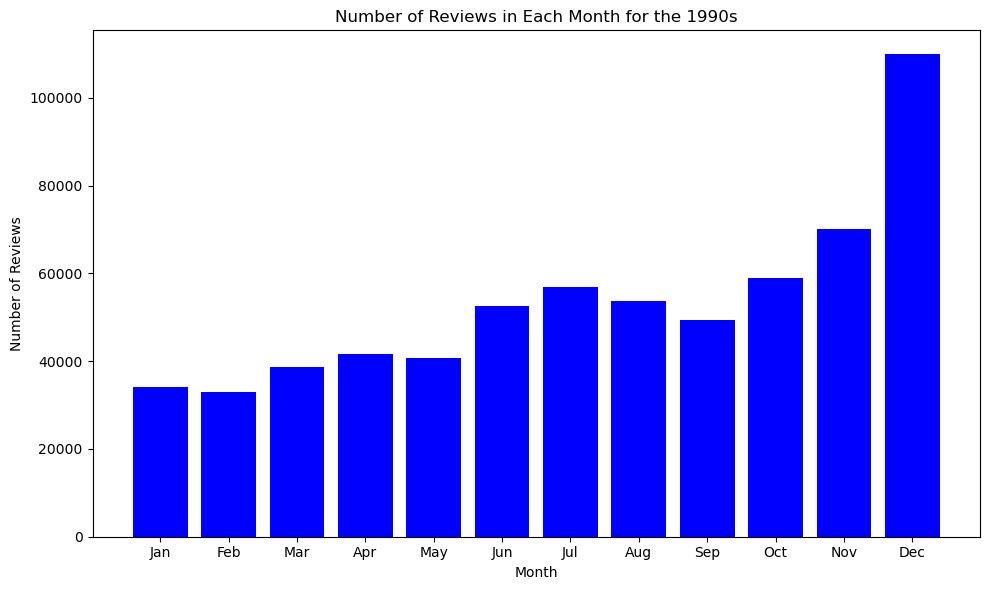

In [32]:
import pandas as pd

reviews_1990 = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "1990s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_1990_pd = reviews_1990.toPandas()

reviews_1990_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.bar(reviews_1990_pd["month"], reviews_1990_pd["review_count"], color='blue')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 1990s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()


#### Plotting graph for 2000s

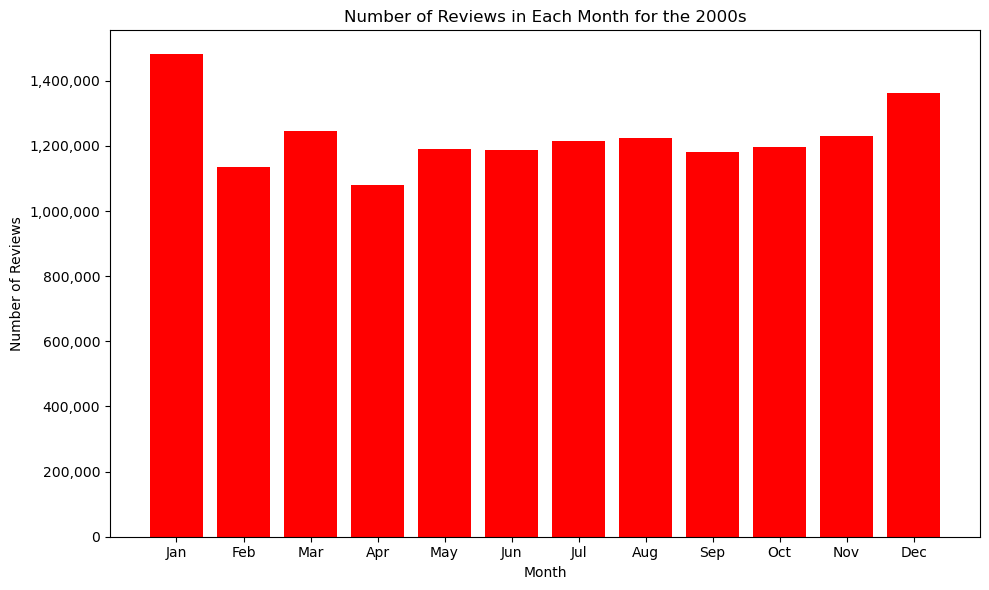

In [33]:


reviews_2000 = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "2000s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_2000_pd = reviews_2000.toPandas()

reviews_2000_pd.columns = ["month", "review_count"]

import matplotlib.ticker as mticker

plt.figure(figsize=(10, 6))
plt.bar(reviews_2000_pd["month"], reviews_2000_pd["review_count"], color='red')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 2000s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()



#### Plotting graph for 2010s

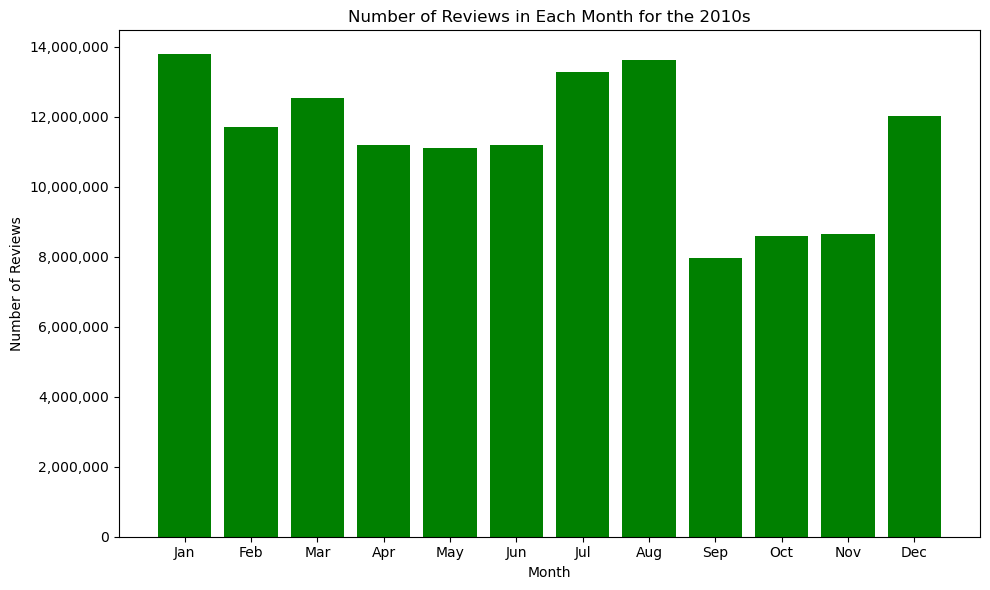

In [35]:
reviews_2010 = monthly_reviews_by_decade.filter(monthly_reviews_by_decade.decade == "2010s") \
                                         .groupBy("month") \
                                         .sum("count") \
                                         .orderBy("month")

reviews_2010_pd = reviews_2010.toPandas()

reviews_2010_pd.columns = ["month", "review_count"]


plt.figure(figsize=(10, 6))
plt.bar(reviews_2010_pd["month"], reviews_2010_pd["review_count"], color='green')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews in Each Month for the 2010s")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

Findings on Seasonality

1990s: The bar chart for the 1990s displays a consistent rise in review counts over the year, culminating in a noticeable peak in December. This pattern suggests that reviews tend to increase toward year-end, likely driven by holiday shopping or end-of-year purchases.

2000s: In the 2000s, a similar trend emerges but on a larger scale. Review counts peak significantly in January, then remain stable through most of the year, with a slight increase in December. This pattern may indicate a surge in post-holiday reviews in January, followed by steady monthly reviews.

2010s: During the 2010s, review volume increases substantially across all months, reflecting the growth of e-commerce. The highest number of reviews occurs in January, with a steady flow throughout the year. Unlike previous decades, there is a decline in September, possibly due to a brief lull in shopping activity.

# 3.1 Consistency of Reviews by Product Category

#### Seasonality consistency of reviews for Books in 2014

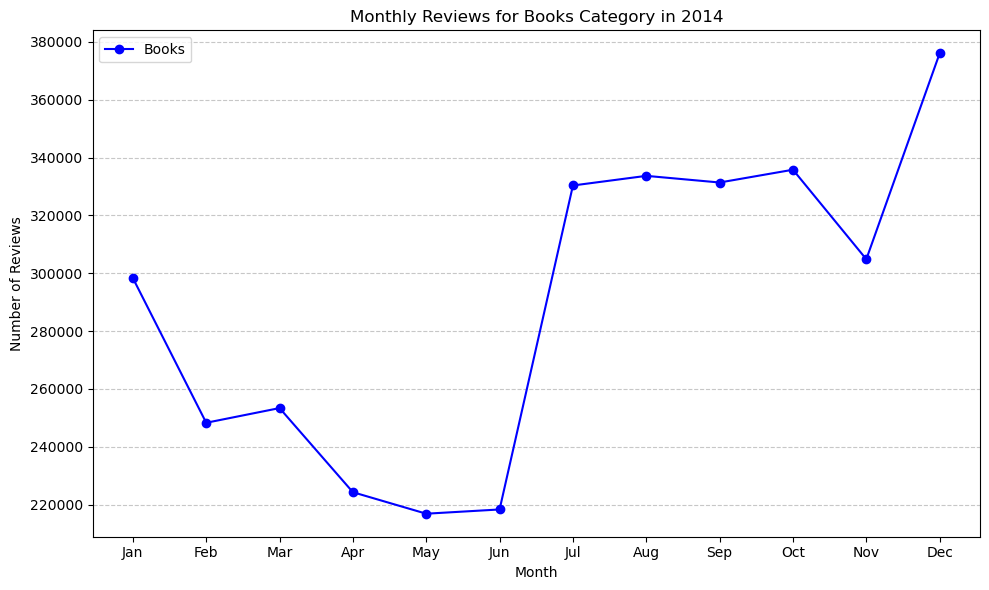

In [36]:
df_books_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Books"))

monthly_reviews_books_2014 = df_books_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_books_2014_pd = monthly_reviews_books_2014.toPandas()
monthly_reviews_books_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_books_2014_pd["month"], monthly_reviews_books_2014_pd["review_count"], marker='o', color='blue', label='Books')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Books Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews forElectronics in 2014

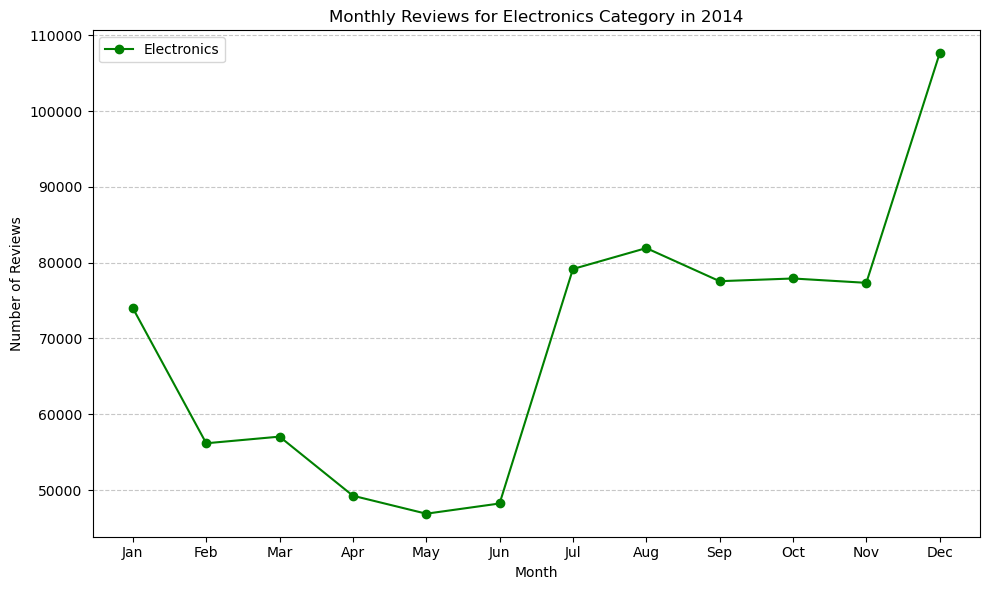

In [37]:
df_electronics_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Electronics"))

monthly_reviews_electronics_2014 = df_electronics_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_electronics_2014_pd = monthly_reviews_electronics_2014.toPandas()
monthly_reviews_electronics_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_electronics_2014_pd["month"], monthly_reviews_electronics_2014_pd["review_count"], marker='o', color='green', label='Electronics')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Electronics Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews for Shoes in 2014

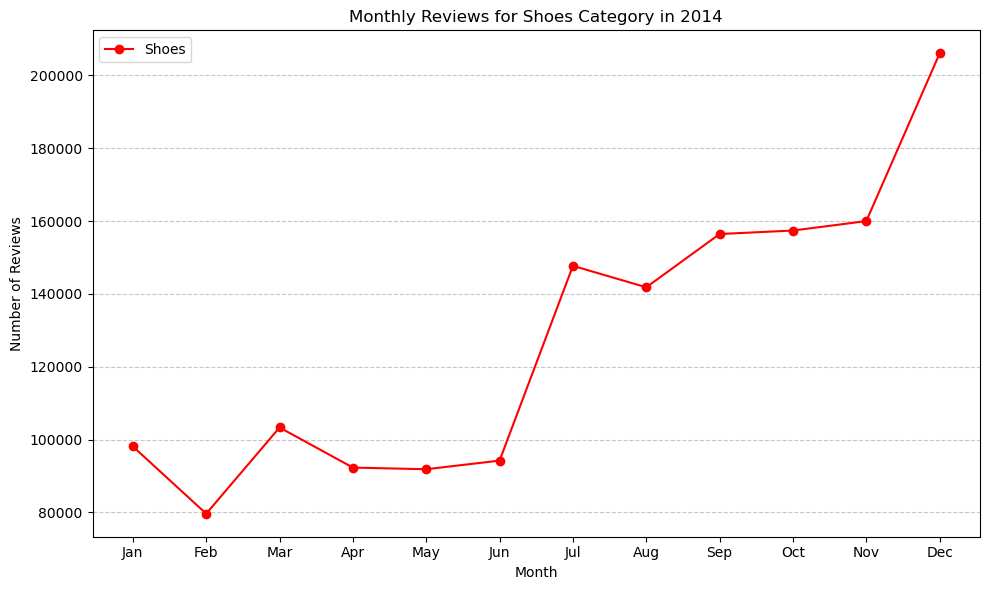

In [38]:
df_shoes_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Shoes"))

monthly_reviews_shoes_2014 = df_shoes_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_shoes_2014_pd = monthly_reviews_shoes_2014.toPandas()
monthly_reviews_shoes_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_shoes_2014_pd["month"], monthly_reviews_shoes_2014_pd["review_count"], marker='o', color='red', label='Shoes')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Shoes Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Seasonality consistency of reviews for Toys in 2014

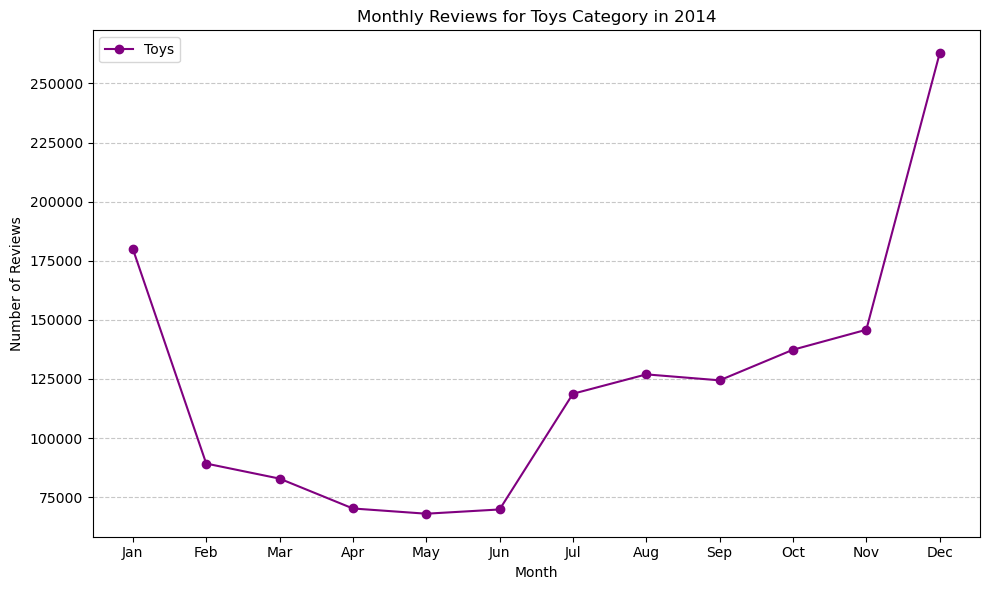

In [39]:
df_toys_2014 = df_cleaned_date.filter((year("review_date") == 2014) & (df_cleaned_date["product_category"] == "Toys"))

monthly_reviews_toys_2014 = df_toys_2014.groupBy(month("review_date").alias("month")).count().orderBy("month")

monthly_reviews_toys_2014_pd = monthly_reviews_toys_2014.toPandas()
monthly_reviews_toys_2014_pd.columns = ["month", "review_count"]

plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews_toys_2014_pd["month"], monthly_reviews_toys_2014_pd["review_count"], marker='o', color='purple', label='Toys')
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Reviews for Toys Category in 2014")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In this analysis, we explored monthly review patterns across four product categories—Electronics, Books, Shoes, and Toys—for the year 2014. Our objective was to assess whether each category maintained a steady review count throughout the year and to identify any seasonal peaks in review activity.

Findings

Electronics:
The Electronics category had relatively lower review counts mid-year, particularly between April and June. However, a notable increase occurred in December, likely driven by holiday shopping and end-of-year purchases.
Conclusion: Electronics reviews are not consistent throughout the year, showing a distinct seasonal rise in December.

Books:
Similar to Electronics, the Books category had fewer reviews in the middle of the year (April to June). Reviews started to increase in July and peaked in December.
Conclusion: Book reviews display seasonal fluctuations, with a consistent rise toward the year’s end, possibly due to holiday gifting.

Shoes:
Reviews for Shoes remained fairly stable from January through October, with a slight increase beginning in July. The largest spike was observed in December, suggesting a higher review volume during the holiday season.
Conclusion: Shoes reviews are relatively stable most of the year but experience a sharp December increase, likely due to seasonal purchases.

Toys:
The Toys category displayed the most distinct seasonal pattern, with a noticeable drop in reviews from February through June. Review counts began to rise in July, culminating in a significant peak in December.
Conclusion: Toys reviews are highly seasonal, with a pronounced surge in December, aligning with holiday gifting trends.

# 3.2 Are product categories getting more reviews during certain times of the year?

Consistency of Reviews:
None of the analyzed product categories maintained a consistent review count throughout the year. Each category showed variations, especially around the holiday season.

Seasonal Trends:
Electronics, Books, Shoes, and Toys all experienced a substantial increase in reviews in December, likely due to holiday shopping.
The Toys category displayed the most prominent seasonality, with a sharp rise in December, likely due to its popularity as a holiday gift choice.

# 4. Which reviews are getting the most helpful votes/ total votes?

In [40]:
from pyspark.sql.functions import desc, col, substring


df_helpful_reviews = df_cleaned_date.filter(df_cleaned_date["helpful_votes"].isNotNull())


# Shortening the length of the "review_body" to 60 characters for easy readability
top_helpful_reviews = df_helpful_reviews \
    .orderBy(desc("helpful_votes")) \
    .select(
        "review_id", 
        "product_category", 
        "helpful_votes", 
        "total_votes", 
        substring(col("review_body"), 1, 60).alias("review_body_truncated") 
    ) \
    .limit(5)

top_helpful_reviews.show(truncate=False)



+--------------+----------------+-------------+-----------+------------------------------------------------------------+
|review_id     |product_category|helpful_votes|total_votes|review_body_truncated                                       |
+--------------+----------------+-------------+-----------+------------------------------------------------------------+
|R3TL1C8CERBRGI|Books           |9992         |10252      |As the father of two teenagers, I found this book invaluable|
|RIWNO96MF2QVV |PC              |9991         |10291      |[[VIDEOID:mo1JKIM8H2U3LT6]]I have loved and used my Kindle K|
|R1UJFMADX2W7HQ|Camera          |999          |1023       |If you're looking for a pocketable camera that has reasonabl|
|R3NYVQL5KSDW84|Books           |999          |1155       |Just to set the record straight on Casual Vacancy, I was giv|
|R2CODY83YSS59M|Beauty          |999          |1048       |After many years of manual brushing, I took the chance on on|
+--------------+----------------

# 4.1 Any correlation between the length of review headline/ review body and the "helpfulness" of the review?

Dividing the length of reviews by the number of characters present in the "review_body" column. 
These are then arranged into 4 buckets: 0-50, 51-100, 101-200, 201-500, 500+

In [41]:
from pyspark.sql.functions import length, col, when, sum as spark_sum
import pandas as pd
import matplotlib.ticker as mticker

df_with_length = df_cleaned_date.withColumn("review_length", length("review_body"))

df_buckets = df_with_length.withColumn(
    "length_bucket",
    when(col("review_length") <= 50, "0-50")
    .when((col("review_length") > 50) & (col("review_length") <= 100), "51-100")
    .when((col("review_length") > 100) & (col("review_length") <= 200), "101-200")
    .when((col("review_length") > 200) & (col("review_length") <= 500), "201-500")
    .when((col("review_length") > 500), "500+")
)

bucket_summary = df_buckets.filter(col("length_bucket").isNotNull()) \
    .groupBy("length_bucket") \
    .agg(
        spark_sum("total_votes").alias("total_votes_sum"),
        spark_sum("helpful_votes").alias("helpful_votes_sum")
    )

order = ["0-50", "51-100", "101-200", "201-500", "500+"]
bucket_summary = bucket_summary.orderBy(col("length_bucket").isin(order).desc(), col("length_bucket"))

bucket_summary_pd = bucket_summary.toPandas()
bucket_summary_pd["length_bucket"] = pd.Categorical(bucket_summary_pd["length_bucket"], categories=order, ordered=True)
bucket_summary_pd = bucket_summary_pd.sort_values("length_bucket")



In [42]:
bucket_summary.show()

+-------------+---------------+-----------------+
|length_bucket|total_votes_sum|helpful_votes_sum|
+-------------+---------------+-----------------+
|         0-50|      9774236.0|        4169587.0|
|      101-200|    5.6467545E7|      3.7278546E7|
|      201-500|    9.7696176E7|      7.1028503E7|
|         500+|   2.07081663E8|     1.68170702E8|
|       51-100|    1.2018031E7|        6932867.0|
+-------------+---------------+-----------------+



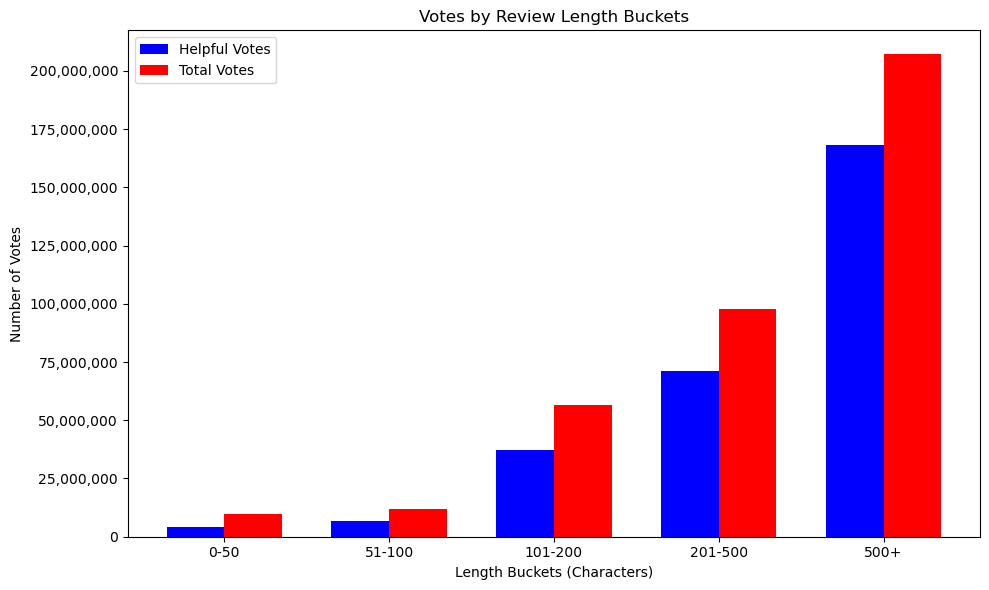

In [43]:
plt.figure(figsize=(10, 6))

bar_width = 0.35
r1 = range(len(bucket_summary_pd["length_bucket"]))
r2 = [x + bar_width for x in r1]

plt.bar(r1, bucket_summary_pd["helpful_votes_sum"], color='blue', width=bar_width, label="Helpful Votes")
plt.bar(r2, bucket_summary_pd["total_votes_sum"], color='red', width=bar_width, label="Total Votes")

plt.xlabel("Length Buckets (Characters)")
plt.ylabel("Number of Votes")
plt.title("Votes by Review Length Buckets")
plt.xticks([r + bar_width/2 for r in range(len(bucket_summary_pd["length_bucket"]))], bucket_summary_pd["length_bucket"])
plt.legend()

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()


This analysis shows a positive correlation between review length and both helpful and total votes, with longer reviews typically attracting higher engagement. The findings suggest that users looking for valuable feedback tend to appreciate more detailed reviews.

Review Length and Votes:
As review length increases, both total votes and helpful votes generally rise, indicating that longer reviews attract more reader engagement, likely due to the detailed insights they provide.
The 500+ character bucket received the highest number of total and helpful votes, highlighting that very detailed reviews are especially valued by readers.

# 4.2 Correlation between how many reviews a certain customer published and the "helpfulness" of the reviews

In [44]:
from pyspark.sql.functions import count, sum as spark_sum

customer_review_summary = df_cleaned_date.groupBy("customer_id").agg(
    count("review_id").alias("total_reviews"),
    spark_sum("total_votes").alias("total_votes_sum"),
    spark_sum("helpful_votes").alias("helpful_votes_sum")
)

customer_review_summary.orderBy("total_reviews", ascending=False).show(truncate=False)


+-----------+-------------+---------------+-----------------+
|customer_id|total_reviews|total_votes_sum|helpful_votes_sum|
+-----------+-------------+---------------+-----------------+
|50122160   |59623        |311666.0       |259768.0         |
|50732546   |30760        |162173.0       |121865.0         |
|52496677   |14367        |106469.0       |93574.0          |
|52004451   |10905        |19117.0        |17605.0          |
|50736950   |10129        |42561.0        |20222.0          |
|18116317   |8723         |30145.0        |27819.0          |
|44731853   |7585         |19084.0        |16572.0          |
|50881246   |7401         |99448.0        |87340.0          |
|38002140   |7197         |17529.0        |9446.0           |
|36642996   |6988         |54383.0        |46232.0          |
|43430756   |6610         |25630.0        |23046.0          |
|50068216   |6540         |37293.0        |25715.0          |
|7080939    |6503         |1107.0         |201.0            |
|3752916

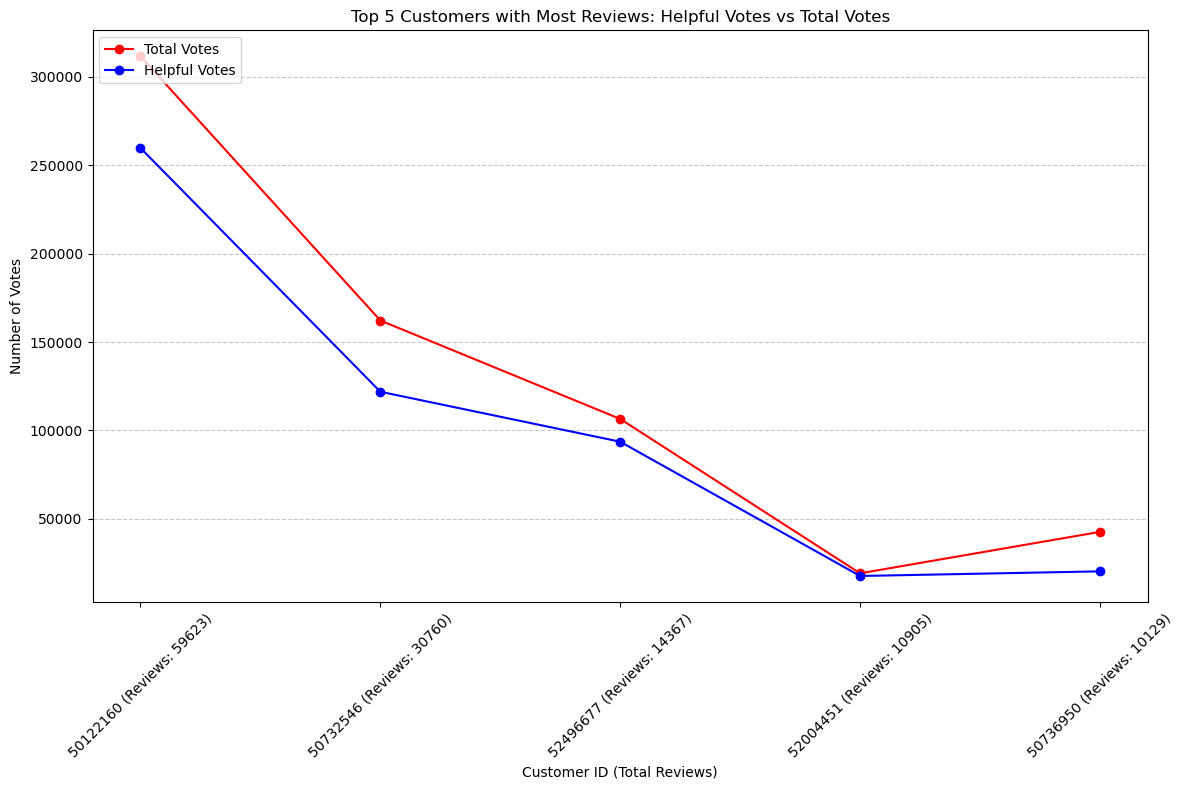

In [45]:
top_5_customers = customer_review_summary.orderBy("total_reviews", ascending=False).limit(5).toPandas()

x_labels = [f"{row['customer_id']} (Reviews: {row['total_reviews']})" for _, row in top_5_customers.iterrows()]

plt.figure(figsize=(12, 8))

plt.plot(x_labels, top_5_customers["total_votes_sum"], marker='o', color='red', label="Total Votes")
plt.plot(x_labels, top_5_customers["helpful_votes_sum"], marker='o', color='blue', label="Helpful Votes")

plt.title("Top 5 Customers with Most Reviews: Helpful Votes vs Total Votes")
plt.xlabel("Customer ID (Total Reviews)")
plt.ylabel("Number of Votes")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()


The analysis shows a positive correlation between the number of reviews a customer publishes and the engagement they receive, measured by helpful votes. Customers who post more reviews tend to have greater visibility, attract more engagement, and are frequently regarded as valuable contributors to the platform.